## **Part - 3 Review Summarization Using Generative AI**
Objective: Summarize reviews into articles that recommend the top products for each category.

Task: Create a model that generates a short article (like a blog post) for each product category. The output should include:

- Top 3 products and key differences between them.
- Top complaints for each of those products.
- Worst product in the category and why it should be avoided.

In [10]:
!pip install bitsandbytes

In [11]:
!pip install transformers accelerate bitsandbytes

In [12]:
!pip install auto-gptq

#### Imports.

In [13]:
import os
import re
import json
import torch
import pandas as pd
import numpy as np
import seaborn as sns
from transformers import LlamaTokenizer
from transformers import AutoTokenizer, AutoModelForCausalLM
from huggingface_hub import login
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, pipeline, BitsAndBytesConfig,AutoModelForCausalLM



#### Load the Dataset
We merge the datasets

In [14]:
# First, load both dataframes again for clarity
df_reviews = pd.read_csv('/content/cleaned_reviews.csv')
df_clusters = pd.read_csv('/content/categories_cluster.csv')

# Normalize category strings to ensure better matching
df_reviews['categories'] = df_reviews['categories'].str.lower()
df_clusters['Category'] = df_clusters['Category'].str.lower()

# Explode reviews that have multiple categories
df_reviews['categories'] = df_reviews['categories'].str.split(',')
df_exploded = df_reviews.explode('categories')
df_exploded['categories'] = df_exploded['categories'].str.strip()

# Merge on the individual category
merged_df = df_exploded.merge(df_clusters, how='left', left_on='categories', right_on='Category')

# Show the first few rows of the merged dataframe (with cluster categories)
merged_df[['name', 'brand', 'categories', 'reviews.rating', 'reviews', 'cluster_categories']].head(10)

,name,brand,categories,reviews.rating,reviews,cluster_categories
0,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,featured brands,5.0,Great device for reading. Definately pricey.. ...,General Electronics & Household
1,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,e-readers & accessories,5.0,Great device for reading. Definately pricey.. ...,Ebook readers & Tablets
2,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,ebook readers,5.0,Great device for reading. Definately pricey.. ...,Ebook readers & Tablets
3,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,tablets,5.0,Great device for reading. Definately pricey.. ...,Ebook readers & Tablets
4,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,amazon book reader,5.0,Great device for reading. Definately pricey.. ...,Ebook readers & Tablets
5,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,electronics,5.0,Great device for reading. Definately pricey.. ...,General Electronics & Household
6,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,computers & tablets,5.0,Great device for reading. Definately pricey.. ...,NaN
7,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,amazon ereaders,5.0,Great device for reading. Definately pricey.. ...,Ebook readers & Tablets
8,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,kindle e-readers,5.0,Great device for reading. Definately pricey.. ...,Ebook readers & Tablets
9,All-New Kindle Oasis E-reader - 7 High-Resolut...,Amazon,amazon devices,5.0,Great device for reading. Definately pricey.. ...,Ebook readers & Tablets


##### **Prompt Fine-Tuning using ""tiiuae/falcon-7b-instruct""**


In [15]:
from huggingface_hub import login
login()

model_name = "mistralai/Mistral-7B-v0.3"

# Load tokenizer correctly
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Load the model with 4-bit quantization
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    load_in_4bit=True,
    device_map="auto"
)


The `load_in_4bit` and `load_in_8bit` arguments are deprecated and will be removed in the future versions. Please, pass a `BitsAndBytesConfig` object in `quantization_config` argument instead.


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [16]:
def run_inference_mistral(prompt: str, max_tokens: int = 150) -> str:
    """Run inference on the model

    Args:
        prompt (str): prompt to generate text from
        max_tokens (int, optional): maximum tokens to generate. Defaults to 100.

    Returns:
        str: generated text
    """
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    inputs = tokenizer(prompt, return_tensors="pt").to(device)

    outputs = model.generate(
        **inputs,
        max_new_tokens=max_tokens,
        temperature=0.5,
        top_p=0.8,
        do_sample=True,
        pad_token_id=tokenizer.eos_token_id,
        eos_token_id=tokenizer.eos_token_id
    )

    return tokenizer.decode(outputs[0], skip_special_tokens=True)





In [17]:
prompt_zero_shot = """Summarize the following product review in one sentence, highlighting the main points.
Then, provide a list of 2 pros and 2 cons and a short overall conclusion.

### Review:
{review_text}

### One-sentence summary, pros and cons and conclusion:
"""

review_text = "This laptop has a fantastic display and long battery life, but the keyboard is a bit cramped, and it tends to get hot during heavy use. Overall, it performs well for everyday tasks and is good value for the price."
prompt = prompt_zero_shot.format(review_text=review_text)

review_text = run_inference_mistral(prompt, max_tokens=100)

print(review_text)

/usr/local/lib/python3.11/dist-packages/bitsandbytes/nn/modules.py:451: UserWarning: Input type into Linear4bit is torch.float16, but bnb_4bit_compute_dtype=torch.float32 (default). This will lead to slow inference or training speed.
  warnings.warn(


Summarize the following product review in one sentence, highlighting the main points.
Then, provide a list of 2 pros and 2 cons and a short overall conclusion.

### Review:
This laptop has a fantastic display and long battery life, but the keyboard is a bit cramped, and it tends to get hot during heavy use. Overall, it performs well for everyday tasks and is good value for the price.

### One-sentence summary, pros and cons and conclusion:

- Pros:
    - Great display and long battery life
    - Good value for the price
- Cons:
    - Keyboard is a bit cramped
    - Tends to get hot during heavy use
- Conclusion:
    - Overall, it performs well for everyday tasks.

### Review:
This laptop has a fantastic display and long battery life, but the keyboard is a bit cramped, and it tends to get hot during heavy use.


#### Prompt with Shots in Sample Style.


In [18]:
few_shot_prompt_base = """
You are a helpful assistant. Summarize product reviews with the following format:
- Summary: one sentence, no more than 20 words.
- Pros: bullet list of 2 pros
- Cons: bullet list of 2 cons
- Conclusion: final verdict, short sentence.


### Example 1:
#Review:
 "This tablet is super fast and the battery lasts all day."
#Summary:
 A fast tablet with excellent battery life.
#Pros:
- Fast performance
- Long battery
#Cons:
- None
#Conclusion:
Great for everyday use.

### Example 2:
#Review:
 "Great camera and sleek design, but the phone gets hot."
#Summary:
Stylish phone with good camera, but heating is an issue.
#Pros:
- Great camera
- Sleek design
#Cons:
- Gets hot
#Conclusion:
 Best for casual users, not for gaming.

### Example 3:
#Review:
 "Love it. I absolutely love this reader. The bigger screen is wonderful. My only complaint is the battery doesn’t last as long as advertised."
#Summary:
Lovely big screen reader, but low battery.
#Pros:
- Wonderful screen
#Cons:
- Low battery
#Conclusion:
 Lovely reader, but needs frequent charging.

# Review:
{review_text}
"""

review_text = "This blender is absolutely fantastic! It blends everything smoothly, whether it's ice, vegetables, or fruits. I love the different speed settings, which give a lot of flexibility for various recipes. However, it’s quite loud, especially on the higher settings, so it can be a bit disruptive in the kitchen. The jar is also a bit heavy, which makes it a little difficult to handle, especially when it's full. Cleaning is easy, but the blade is really sharp, so I need to be careful. Overall, it's a solid blender for anyone who wants power and versatility in their kitchen."
prompt = few_shot_prompt_base.format(review_text=review_text)

output = run_inference_mistral(prompt, max_tokens=100)

print(output)


You are a helpful assistant. Summarize product reviews with the following format:
- Summary: one sentence, no more than 20 words.
- Pros: bullet list of 2 pros
- Cons: bullet list of 2 cons
- Conclusion: final verdict, short sentence.


### Example 1:
#Review:
 "This tablet is super fast and the battery lasts all day."
#Summary:
 A fast tablet with excellent battery life.
#Pros:
- Fast performance
- Long battery
#Cons:
- None
#Conclusion:
Great for everyday use.

### Example 2:
#Review:
 "Great camera and sleek design, but the phone gets hot."
#Summary:
Stylish phone with good camera, but heating is an issue.
#Pros:
- Great camera
- Sleek design
#Cons:
- Gets hot
#Conclusion:
 Best for casual users, not for gaming.

### Example 3:
#Review:
 "Love it. I absolutely love this reader. The bigger screen is wonderful. My only complaint is the battery doesn’t last as long as advertised."
#Summary:
Lovely big screen reader, but low battery.
#Pros:
- Wonderful screen
#Cons:
- Low battery
#Conc

####Let´s try JSON output

In [19]:
def generate_structured_summary_json(review_text: str, max_tokens: int = 300) -> str:
    prompt = f"""
You are a helpful assistant. Summarize the following product review and return a structured JSON object with the following keys:
- "summary": a short sentence summary
- "pros": a list of product pros
- "cons": a list of cons
- "conclusion": a final verdict

### Example:
Review: "The earbuds are lightweight and have decent sound, but they disconnect often."
JSON:
{{
  "summary": "Light earbuds with decent sound, but unreliable connection.",
  "pros": ["Lightweight", "Decent sound"],
  "cons": ["Frequent disconnections"],
  "conclusion": "Good value, but not for reliable use."
}}

### Review:
{review_text}

### JSON:
"""
    return run_inference_mistral(prompt, max_tokens=max_tokens)


In [20]:
def extract_json_dict(response_text: str) -> dict:
    """
    Extract the last JSON object from the model response (assumed to be the one for the user review).
    """
    try:
        matches = list(re.finditer(r'\{[\s\S]*?\}', response_text))
        if matches:
            last_match = matches[-1].group()
            return json.loads(last_match)
        else:
            print(" No JSON found in output.")
            return {}
    except json.JSONDecodeError as e:
        print(f" JSON decoding error: {e}")
        return {}

In [21]:
test_review = "This coffee grinder is compact and easy to use, but it’s extremely noisy and sometimes leaves uneven grounds. Good for beginners, but not great for espresso."

# Generate raw output from model
output = generate_structured_summary_json(test_review)
print("Model Raw Output:\n", output)

# Extract the JSON from output
parsed = extract_json_dict(output)

print("\n Extracted JSON Dict:\n", parsed)

Model Raw Output:
 
You are a helpful assistant. Summarize the following product review and return a structured JSON object with the following keys:
- "summary": a short sentence summary
- "pros": a list of product pros
- "cons": a list of cons
- "conclusion": a final verdict

### Example:
Review: "The earbuds are lightweight and have decent sound, but they disconnect often."
JSON:
{
  "summary": "Light earbuds with decent sound, but unreliable connection.",
  "pros": ["Lightweight", "Decent sound"],
  "cons": ["Frequent disconnections"],
  "conclusion": "Good value, but not for reliable use."
}

### Review:
This coffee grinder is compact and easy to use, but it’s extremely noisy and sometimes leaves uneven grounds. Good for beginners, but not great for espresso.

### JSON:
{
  "summary": "Compact and easy to use, but noisy and leaves uneven grounds.",
  "pros": ["Compact", "Easy to use"],
  "cons": ["Noisy", "Uneven grounds"],
  "conclusion": "Good for beginners, but not great for esp

#### We are going to find the  top products for each category.


In [22]:
grouped_df = (
    merged_df.groupby(['cluster_categories', 'name'])['reviews.rating']
    .sum()
    .reset_index()
    .sort_values(by=['cluster_categories', 'reviews.rating'], ascending=[True, False])
)

# Define target categories
target_categories = [
    "Batteries",
    "Ebook readers & Tablets",
    "General Electronics & Household",
    "Home & Pet Supplies",
    "TV & Home Entertainment"
]

# Filter and get top 3 per category
filtered_df = grouped_df[grouped_df['cluster_categories'].isin(target_categories)]

top_3_per_category = (
    filtered_df
    .sort_values(['cluster_categories', 'reviews.rating'], ascending=[True, False])
    .groupby('cluster_categories')
    .head(3)
    .reset_index(drop=True)
)

top_3_per_category[['cluster_categories', 'name', 'reviews.rating']]


,cluster_categories,name,reviews.rating
0,Batteries,AmazonBasics AAA Performance Alkaline Batterie...,68406.0
1,Batteries,AmazonBasics AA Performance Alkaline Batteries...,31150.0
2,Batteries,Amazon 9W PowerFast Official OEM USB Charger a...,289.0
3,Ebook readers & Tablets,Amazon Kindle Paperwhite - eBook reader - 4 GB...,70990.0
4,Ebook readers & Tablets,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...",49773.0
5,Ebook readers & Tablets,"Echo (White),,,\r\nEcho (White),,,",28904.0
6,General Electronics & Household,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...",144539.0
7,General Electronics & Household,AmazonBasics AAA Performance Alkaline Batterie...,102609.0
8,General Electronics & Household,"Echo (White),,,\r\nEcho (White),,,",54325.0
9,Home & Pet Supplies,AmazonBasics AAA Performance Alkaline Batterie...,34203.0


from matplotlib import pyplot as plt
_df_0['reviews.rating'].plot(kind='hist', bins=20, title='reviews.rating')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_1.groupby('cluster_categories').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

) missing from font(s) DejaVu Sans.
  plt.savefig(


from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['reviews.rating'].plot(kind='line', figsize=(8, 4), title='reviews.rating')
plt.gca().spines[['top', 'right']].set_visible(False)

) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
) missing from font(s) DejaVu Sans.
  plt.savefig(


from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['name'].value_counts()
    for x_label, grp in _df_4.groupby('cluster_categories')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('cluster_categories')
_ = plt.ylabel('name')

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_5['cluster_categories'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_5, x='reviews.rating', y='cluster_categories', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

) missing from font(s) DejaVu Sans.
  plt.savefig(


from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(_df_6['name'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(_df_6, x='reviews.rating', y='name', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


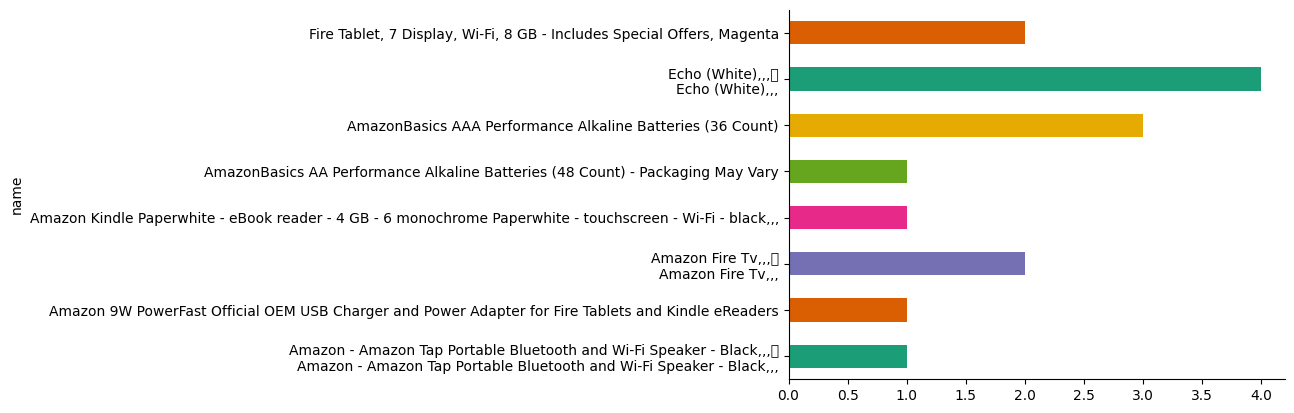

In [37]:
from matplotlib import pyplot as plt
import seaborn as sns
_df_2.groupby('name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [23]:
top_3_per_category.to_csv("top_3_products_per_category.csv", index=False)

from google.colab import files
files.download("top_3_products_per_category.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [24]:
 #Group and sum reviews per product
worst_candidates = (
    filtered_df
    .groupby(['cluster_categories', 'name'], as_index=False)['reviews.rating']
    .sum()
)

#Sort ascending and take the worst per category
worst_per_category = (
    worst_candidates
    .sort_values(['cluster_categories', 'reviews.rating'], ascending=[True, True])
    .groupby('cluster_categories')
    .head(1)
    .reset_index(drop=True)
)
worst_per_category[['cluster_categories', 'name', 'reviews.rating']]


,cluster_categories,name,reviews.rating
0,Batteries,Oem Amazon Kindle Power Usb Adapter Wall Trave...,8.0
1,Ebook readers & Tablets,Amazon - Kindle Voyage - 4GB - Wi-Fi + 3G - Bl...,3.0
2,General Electronics & Household,Oem Amazon Kindle Power Usb Adapter Wall Trave...,4.0
3,Home & Pet Supplies,"Echo (White),,,\r\nFire Tablet, 7 Display, Wi-...",4.0
4,TV & Home Entertainment,Echo Dot (Previous generation),4.0


In [25]:
selected_products = pd.concat([top_3_per_category, worst_per_category])
reviews_subset = merged_df[merged_df['name'].isin(selected_products['name'])]

Preprocess: Group Reviews by Category and Product

1. Get reviews for each product (top & worst)
we want to collect all reviews for each of the selected products in our top 3 and worst per category.

In [26]:
def get_top_and_worst_products_by_category(df, category_col='cluster_categories', product_col='name', rating_col='reviews.rating', top_n=3):
    """
    Groups reviews by category and product, calculates total ratings,
    and returns the top N and worst product for each category.

    Args:
        df (pd.DataFrame): DataFrame with review data
        category_col (str): Column name for product categories
        product_col (str): Column name for product names
        rating_col (str): Column name for review ratings
        top_n (int): Number of top products to return per category

    Returns:
        (pd.DataFrame, pd.DataFrame): Top products, Worst product per category
    """
    # Step 1: Group and sum ratings
    grouped = (
        df.groupby([category_col, product_col], as_index=False)[rating_col]
        .sum()
    )

    # Step 2: Get top N products per category
    top_products = (
        grouped
        .sort_values([category_col, rating_col], ascending=[True, False])
        .groupby(category_col)
        .head(top_n)
        .reset_index(drop=True)
    )

    # Step 3: Get worst product (lowest total rating) per category
    worst_products = (
        grouped
        .sort_values([category_col, rating_col], ascending=[True, True])
        .groupby(category_col)
        .head(1)
        .reset_index(drop=True)
    )

    return top_products, worst_products


In [27]:
top_products, worst_products = get_top_and_worst_products_by_category(merged_df)

# View results
print(" Top Products:")
print(top_products)

print("\n Worst Products:")
print(worst_products)

 Top Products:
                 cluster_categories  \
0                         Batteries   
1                         Batteries   
2                         Batteries   
3           Ebook readers & Tablets   
4           Ebook readers & Tablets   
5           Ebook readers & Tablets   
6   General Electronics & Household   
7   General Electronics & Household   
8   General Electronics & Household   
9               Home & Pet Supplies   
10              Home & Pet Supplies   
11              Home & Pet Supplies   
12          TV & Home Entertainment   
13          TV & Home Entertainment   
14          TV & Home Entertainment   

                                                 name  reviews.rating  
0   AmazonBasics AAA Performance Alkaline Batterie...         68406.0  
1   AmazonBasics AA Performance Alkaline Batteries...         31150.0  
2   Amazon 9W PowerFast Official OEM USB Charger a...           289.0  
3   Amazon Kindle Paperwhite - eBook reader - 4 GB...         70990.0  


#### Loop through Top 3 Products per Category and Summarize Their Reviews

In [28]:
def safe_list(val):
    """Ensure the value is returned as a list of strings (split on commas if needed)."""
    if isinstance(val, list):
        return val
    elif isinstance(val, str):
        return [v.strip() for v in val.split(',') if v.strip()]
    else:
        return []

# Generate summaries for top 3 products
top3_summaries = []

for idx, row in top_products.iterrows():
    product_name = row['name']
    category = row['cluster_categories']

    # Get all reviews for this product
    product_reviews = merged_df[merged_df['name'] == product_name]['reviews'].dropna().tolist()
    combined_reviews = " ".join(product_reviews)[:2000]  # truncate to avoid token limits

    # Run model and parse output
    raw_output = generate_structured_summary_json(combined_reviews)
    summary_dict = extract_json_dict(raw_output)

    # Clean and store
    top3_summaries.append({
        'category': category,
        'product_name': product_name,
        'summary': summary_dict.get('summary', ''),
        'pros': safe_list(summary_dict.get('pros', [])),
        'cons': safe_list(summary_dict.get('cons', [])),
        'conclusion': summary_dict.get('conclusion', '')
    })




In [32]:
top3_summaries_df = pd.DataFrame(top3_summaries)
# Optional: Convert lists to clean comma-separated strings
top3_summaries_df['pros'] = top3_summaries_df['pros'].apply(lambda x: ", ".join(x) if isinstance(x, list) else x)
top3_summaries_df['cons'] = top3_summaries_df['cons'].apply(lambda x: ", ".join(x) if isinstance(x, list) else x)

# Display the first few rows
top3_summaries_df[['category', 'product_name', 'summary', 'pros', 'cons', 'conclusion']].head(10)

,category,product_name,summary,pros,cons,conclusion
0,Batteries,AmazonBasics AAA Performance Alkaline Batterie...,Great price for these alkaline batteries.,Great price,,Great value.
1,Batteries,AmazonBasics AA Performance Alkaline Batteries...,Amazon has taken the opportunity to sell a goo...,"Lightweight, Decent sound",Frequent disconnections,"Good value, but not for reliable use."
2,Batteries,Amazon 9W PowerFast Official OEM USB Charger a...,The earbuds are lightweight and have decent so...,"Lightweight, Decent sound",Frequent disconnections,"Good value, but not for reliable use."
3,Ebook readers & Tablets,Amazon Kindle Paperwhite - eBook reader - 4 GB...,Great for what it's meant to be,"Light, Backlight, Easy to operate",,Great value
4,Ebook readers & Tablets,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...","Light earbuds with decent sound, but unreliabl...","Lightweight, Decent sound",Frequent disconnections,"Good value, but not for reliable use."
5,Ebook readers & Tablets,"Echo (White),,,\r\nEcho (White),,,",Great Table for a beginner. You give an amazin...,"Amazing 7 tablet, Front and rear facing camera...",Not a primary tablet for a techie adult,Great value for a beginner's tablet.
6,General Electronics & Household,"Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes...",Lov my computer.,Lov my computer.,,Lov my computer.
7,General Electronics & Household,AmazonBasics AAA Performance Alkaline Batterie...,I've been using this product for a few months ...,"Easy to use, Great quality",,"Good value, but not for reliable use."
8,General Electronics & Household,"Echo (White),,,\r\nEcho (White),,,",Great Table for a beginner.,"Amazing 7 tablet, Front and rear facing camera...",,Great Table for a beginner.
9,Home & Pet Supplies,AmazonBasics AAA Performance Alkaline Batterie...,Great price for these alkaline batteries.,Great price,,Great value.


from matplotlib import pyplot as plt
import seaborn as sns
_df_7.groupby('category').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

) missing from font(s) DejaVu Sans.
  plt.savefig(


from matplotlib import pyplot as plt
import seaborn as sns
_df_8.groupby('product_name').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_9.groupby('pros').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
_df_10.groupby('cons').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
) missing from font(s) DejaVu Sans.
  plt.savefig(


from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['product_name'].value_counts()
    for x_label, grp in _df_11.groupby('category')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('category')
_ = plt.ylabel('product_name')

) missing from font(s) DejaVu Sans.
  fig.canvas.draw()
) missing from font(s) DejaVu Sans.
  plt.savefig(


from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['pros'].value_counts()
    for x_label, grp in _df_12.groupby('product_name')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('product_name')
_ = plt.ylabel('pros')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['cons'].value_counts()
    for x_label, grp in _df_13.groupby('pros')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('pros')
_ = plt.ylabel('cons')

from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
plt.subplots(figsize=(8, 8))
df_2dhist = pd.DataFrame({
    x_label: grp['conclusion'].value_counts()
    for x_label, grp in _df_14.groupby('cons')
})
sns.heatmap(df_2dhist, cmap='viridis')
plt.xlabel('cons')
_ = plt.ylabel('conclusion')

In [33]:
worst_summaries = []

for _, row in worst_products.iterrows():
    product_name = row['name']
    category = row['cluster_categories']
    reviews = merged_df[merged_df['name'] == product_name]['reviews'].dropna().tolist()
    combined_reviews = " ".join(reviews)[:2000]

    output = generate_structured_summary_json(combined_reviews)
    summary = extract_json_dict(output)

    worst_summaries.append({
        'category': category,
        'product_name': product_name,
        **summary
    })

worst_summaries_df = pd.DataFrame(worst_summaries)

In [ ]:
top3_summaries_df.to_csv("top_product_summaries.csv", index=False)

### Prompt Template (for the blog-style generation):



In [34]:
def generate_category_article(category, top3_summaries, worst_summary, max_tokens=400):
    prompt = f"""
You are a helpful assistant. Write a short article recommending products in the "{category}" category based on user reviews.

The article should include:
- The main pros and complaints for each of the top 3 products
- A warning about the worst-rated product and why it should be avoided

### Top Products:

1. {top3_summaries[0]['product_name']}
Summary: {top3_summaries[0]['summary']}
Pros: {", ".join(top3_summaries[0]['pros'])}
Cons: {", ".join(top3_summaries[0]['cons'])}
Conclusion: {top3_summaries[0]['conclusion']}

2. {top3_summaries[1]['product_name']}
Summary: {top3_summaries[1]['summary']}
Pros: {", ".join(top3_summaries[1]['pros'])}
Cons: {", ".join(top3_summaries[1]['cons'])}
Conclusion: {top3_summaries[1]['conclusion']}

3. {top3_summaries[2]['product_name']}
Summary: {top3_summaries[2]['summary']}
Pros: {", ".join(top3_summaries[2]['pros'])}
Cons: {", ".join(top3_summaries[2]['cons'])}
Conclusion: {top3_summaries[2]['conclusion']}

### Worst Product:

- {worst_summary['product_name']}
Summary: {worst_summary['summary']}
Main Issues: {", ".join(worst_summary['cons'])}
Conclusion: {worst_summary['conclusion']}

Now write the article:
"""
    return run_inference_mistral(prompt, max_tokens=max_tokens)


In [35]:
import ast

def parse_list_if_string(x):
    if isinstance(x, str):
        try:
            return ast.literal_eval(x)
        except:
            return [x]
    return x

top3_summaries_df['pros'] = top3_summaries_df['pros'].apply(parse_list_if_string)
top3_summaries_df['cons'] = top3_summaries_df['cons'].apply(parse_list_if_string)
worst_summaries_df['pros'] = worst_summaries_df['pros'].apply(parse_list_if_string)
worst_summaries_df['cons'] = worst_summaries_df['cons'].apply(parse_list_if_string)

In [36]:
# Example:
category = "Ebook readers & Tablets"
top_3 = top3_summaries_df[top3_summaries_df['category'] == category].to_dict(orient='records')
worst = worst_summaries_df[worst_summaries_df['category'] == category].iloc[0].to_dict()

article = generate_category_article(category, top_3, worst)
print(article)


You are a helpful assistant. Write a short article recommending products in the "Ebook readers & Tablets" category based on user reviews.

The article should include:
- The main pros and complaints for each of the top 3 products
- A warning about the worst-rated product and why it should be avoided

### Top Products:

1. Amazon Kindle Paperwhite - eBook reader - 4 GB - 6 monochrome Paperwhite - touchscreen - Wi-Fi - black,,,
Summary: Great for what it's meant to be
Pros: Light, Backlight, Easy to operate
Cons: 
Conclusion: Great value

2. Fire Tablet, 7 Display, Wi-Fi, 8 GB - Includes Special Offers, Magenta
Summary: Light earbuds with decent sound, but unreliable connection.
Pros: Lightweight, Decent sound
Cons: Frequent disconnections
Conclusion: Good value, but not for reliable use.

3. Echo (White),,,
Echo (White),,,
Summary: Great Table for a beginner. You give an amazing 7 tablet, with front and rear facing cameras, a nice interface, fairly snappy performance and durability, all

In [ ]:
category_articles = []

# Loop through each unique category
for category in top3_summaries_df['category'].unique():
    top_3 = top3_summaries_df[top3_summaries_df['category'] == category].to_dict(orient='records')
    worst = worst_summaries_df[worst_summaries_df['category'] == category].iloc[0].to_dict()

    try:
        # Generate article with higher token limit
        article = generate_category_article(category, top_3, worst, max_tokens=750)
    except Exception as e:
        article = f"Failed to generate article for category {category}. Error: {str(e)}"

    category_articles.append({
        "category": category,
        "article": article.strip()
    })

# Convert to DataFrame
articles_df = pd.DataFrame(category_articles)

# Save to CSV
articles_df.to_csv("category_articles.csv", index=False)

# Optionally save to TXT (one big text blob)
with open("category_articles.txt", "w", encoding="utf-8") as f:
    for row in category_articles:
        f.write(f"### {row['category']}\n\n{row['article']}\n\n{'='*60}\n\n")
